In [1]:
import sys
sys.path.append('..')
from mtDNAsim import *
import pandas as pd
import numpy as np
from copy import deepcopy
from collections import Counter
import argparse
import pickle

/home/wangkun/mtDNA_simulation/scripts/../mtDNAsim/sim_utils.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [24]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

In [ ]:
num_elements = 1
# while True:
success = 1
def death_rate(t):
    if t > 25:
        return 0.8
    else:
        return 0.2
# while success:
    # try:
system = Gillespie(
    num_elements,
    inits=[1],
    max_cell_num=50000,
    max_genetion_time=131
)

p0 = lambda t: 0.8
# dr = lambda t: death_rate
system.add_reaction(p0, [1], [2], index=0) # 0 self renew
system.add_reaction(death_rate, [1], [0], index=13) # 3 -> 4 differentiation
system.evolute(100000000)
success = 0
    # except:
    #     pass


  0%|          | 0/131 [00:00<?, ?it/s]

In [15]:
len(system.curr_cells[0])

8692

In [3]:
data_path = '/home/wangkun/mtDNA_simulation/data'
simid = '130_gen'

In [17]:
curr_cells = []

for i in system.curr_cells.values():
    curr_cells += i

sim_utils.wirte_lineage_info(
    f"{data_path}/{simid}/lineage_info.csv", system.anc_cells, curr_cells, system.t[-1]
)

reconstruct(f"{data_path}/{simid}/lineage_info.csv", output=f"{data_path}/{simid}/gt_tree.nwk", num=1000, is_balance=True)

tree = loadtree(f'{data_path}/{simid}/gt_tree.nwk')[0]

for i in tree.get_nonterminals():
    i.branch_length=1
for i in tree.get_terminals():
    i.branch_length=1
    
Phylo.write(tree, f'{data_path}/{simid}/gt_tree.nwk', format='newick')

1

In [46]:
tree = loadtree(f'{data_path}/{simid}/gt_tree.nwk')[0]
for i in tree.get_terminals():
    for j in tree.get_path(i)[::-1][1:]:
        if len(j.clades) == 1:
            tree.collapse(j)
Phylo.write(tree, f'{data_path}/{simid}/gt_tree_collapse.nwk', format='newick')

KeyboardInterrupt: 

In [6]:
nrm = 100

imr = nrm / 1000
mt_mutrate = 0.8
n_mts = 500
bn = 'const'
mt_cn = {
    'mid':lambda x: 1.52 if x <= 10 else (2.85 if x <= 20 else 2),
    'const':lambda x: 2 
}

# success = 0
# while not success:
#     try:
mt_muts, mutid = mtmutation(tree, mut_rate=mt_mutrate/n_mts, init_mut_rate=imr, mt_copynumber=mt_cn[bn], nmts=n_mts)
n_root_muts = len(set(sum([list(i) for i in mt_muts['<0_0>']], [])))
if nrm == 0:
    success = 1
elif np.abs(n_root_muts-nrm)/nrm <= 0.2:
    success = 1
else:
    pass
    # except:
    #     pass

pickle.dump(mt_muts, open(f"{data_path}/{simid}/mt_allmuts_130.pkl", 'wb'))

  0%|          | 0/499 [00:00<?, ?it/s]

Simulating MT mutation::   0%|          | 0/2000 [00:00<?, ?it/s]

In [9]:
mt_freq = sparse_freq(mt_muts)
tree_gt = Phylo.read(f'{data_path}/{simid}/gt_tree_collapse.nwk', format='newick')
mt_freq_leave = mt_freq.loc[[i.name for i in tree_gt.get_terminals()]]
mt_freq_samp = sequence_sim(mt_freq_leave, 50, n=2.5)
for cutoff in [0, 0.01]:
    for suf, freq in zip(['', '_seq'], [mt_freq_leave, mt_freq_samp]):
        muts = freq>cutoff
        muts = muts.iloc[:, np.where(muts.sum(0)>0)[0]]
        muts = muts.astype(int).astype(str)
        translation_table = str.maketrans({'1': 'A', '0': 'G'})
        seqs = f'{muts.shape[0]} {muts.shape[1]}\n'
        for i in range(muts.shape[0]):
            seqs += f'{muts.index[i]} '
            seqs += ''.join(muts.iloc[i].to_numpy()).translate(translation_table)
            seqs += '\n'
        with open(f'{data_path}/{simid}/mt_allmuts_130_{cutoff}{suf}.phy', 'w') as f:
            f.write(seqs)



  0%|          | 0/2000 [00:00<?, ?it/s]

/home/wangkun/mtDNA_simulation/scripts/../mtDNAsim/sim_utils.py:799: RuntimeWarning: invalid value encountered in divide
  freq_samp = rc/depth


In [12]:

mt_muts = pickle.load(open(f'{data_path}/{simid}/mt_allmuts_130.pkl', 'rb'))
freq = sparse_freq(mt_muts)
tree_gt = Phylo.read(f'{data_path}/{simid}/gt_tree.nwk', 'newick')
freq = freq.loc[[i.name for i in tree_gt.get_terminals()]]
cells = list(freq.index)
np.random.shuffle(cells)
freq = freq.loc[cells]
read_cnt, freq_samp = sequence_sim(freq, 50, 2.5, True, [1,2])

read_cnt.to_csv(f'{data_path}/{simid}/sequence_readcount_130.csv')
for suf, freq in zip(['_seq1', '_seq2'],freq_samp):
    for cutoff in [0, 0.01]:
        muts = freq>cutoff
        muts = muts.iloc[:, np.where(muts.sum(0)>0)[0]]
        muts = muts.astype(int).astype(str)
        translation_table = str.maketrans({'1': 'A', '0': 'G'})
        seqs = f'{muts.shape[0]} {muts.shape[1]}\n'
        for i in range(muts.shape[0]):
            seqs += f'{muts.index[i]} '
            seqs += ''.join(muts.iloc[i].to_numpy()).translate(translation_table)
            seqs += '\n'
        with open(f'{data_path}/{simid}/mt_allmuts_130_{cutoff}{suf}.phy', 'w') as f:
            f.write(seqs)


  0%|          | 0/2000 [00:00<?, ?it/s]

/home/wangkun/mtDNA_simulation/scripts/../mtDNAsim/sim_utils.py:793: RuntimeWarning: invalid value encountered in divide
  freq_samp = rc/depth


In [13]:
gen = 130
for cutoff in [0, 0.01]:
    for i in range(1,3):
        fn = f'mt_allmuts_{gen}_{cutoff}_seq{i}.phy'
        os.system(f'Rscript /home/wangkun/mtDNA_simulation/scripts/tree_reconstruct.r -p {data_path}/{simid} -f {fn}')

In [14]:
gen = 130
for cutoff in [0, 0.01]:
    fn = f'mt_allmuts_{gen}_{cutoff}.phy'
    os.system(f'Rscript /home/wangkun/mtDNA_simulation/scripts/tree_reconstruct.r -p {data_path}/{simid} -f {fn}')

In [15]:
def DNAmutation(tree, mut_rate=0.1):
    mutations = dict()
    global_mutid = -1
    for i in tree.get_terminals():
        mut = []
        for j in tree.get_path(i):
            if j in mutations:
                mut = deepcopy(mutations[j])
            else:
                for _ in range(np.random.poisson(mut_rate*j.branch_length)):
                    mut.append(global_mutid+1)
                    global_mutid += 1
                mutations[j] = deepcopy(mut)

    mut_table = []
    cell_names = []
    for i in tree.get_terminals():
        seq = np.zeros(global_mutid+1)
        seq[mutations[i]]=1
        mut_table.append(seq)
        cell_names.append(i.name)
    return pd.DataFrame(np.array(mut_table), index=cell_names)


gen = 130
tree = Phylo.read(f'{data_path}/{simid}/gt_tree_collapse.nwk', 'newick')
ndna_mut = DNAmutation(tree, mut_rate=0.8)
seqs = ndna_mut.astype(int)
with open(f'{data_path}/{simid}/dna_mut{gen}.phy', 'w') as f:
    f.write('{} {}\n'.format(*seqs.shape))
    for cell in seqs.index:
        f.write('{} {}\n'.format(cell, ''.join(seqs.loc[cell].astype(str)).replace('1', 'A').replace('0', 'G')))
os.system(f'Rscript /home/wangkun/mtDNA_simulation/scripts/tree_reconstruct.r -p {data_path}/{simid} -f dna_mut{gen}.phy')

0

In [65]:
def get_gt_dist(tree_mt, tree_gt, niter=100):
    pairs = []
    cnt = 0
    tree_mt_copy = deepcopy(tree_mt)
    all_cells = tree_mt_copy.get_terminals()
    for i in tree_mt_copy.get_terminals():
        i.branch_length=1
    for i in tree_mt_copy.get_nonterminals():
        i.branch_length=1
    with tqdm(total=niter) as pbar:
        while cnt < niter:
            c1 = all_cells[np.random.choice(range(len(all_cells)))]
            for anc in tree_mt_copy.get_path(c1)[::-1][1:]:
                if len(anc.get_terminals())<2:
                    continue
                siss, dists = [], []
                for sis in anc.get_terminals():
                    siss.append(sis)
                    dists.append(tree_mt_copy.distance(c1, sis))

                c2 = siss[np.where(np.argsort(dists)==len(dists)-1)[0][0]]
                pairs.append((c1.name, c2.name))
                cnt += 1
                pbar.update(1)
                break
            
    dist_gt = []
    for i in pairs:
        c1, c2 = tree_gt.find_any(i[0]), tree_gt.find_any(i[1])
        dist_gt.append(tree_gt.distance(c1, c2))
    return np.array(dist_gt)/2

In [19]:
path = f'{data_path}/{simid}'
tree_gt = Phylo.read(f'{path}/gt_tree_collapse.nwk', 'newick')
tree_mt = Phylo.read(f'{path}/mt_allmuts_130_0.phy_nj.nwk', 'newick')
tree_ndna = Phylo.read(f'{path}/dna_mut130.phy_nj.nwk', 'newick')
tree_mt1 = Phylo.read(f'{path}/mt_allmuts_130_0.01.phy_nj.nwk', 'newick')
tree_mt_seq1 = Phylo.read(f'{path}/mt_allmuts_130_0_seq1.phy_nj.nwk', 'newick')
tree_mt1_seq1 = Phylo.read(f'{path}/mt_allmuts_130_0.01_seq1.phy_nj.nwk', 'newick')
tree_mt_seq2 = Phylo.read(f'{path}/mt_allmuts_130_0_seq2.phy_nj.nwk', 'newick')
tree_mt1_seq2 = Phylo.read(f'{path}/mt_allmuts_130_0.01_seq2.phy_nj.nwk', 'newick')

niter = 500
dist_mt100 = get_gt_dist(tree_mt, tree_gt, niter=niter)
dist_ndna100 = get_gt_dist(tree_ndna, tree_gt, niter=niter)
dist_mt1100 = get_gt_dist(tree_mt1, tree_gt, niter=niter)
dist_mt_seq1100 = get_gt_dist(tree_mt_seq1, tree_gt, niter=niter)
dist_mt1_seq1100 = get_gt_dist(tree_mt1_seq1, tree_gt, niter=niter)
dist_mt_seq2100 = get_gt_dist(tree_mt_seq2, tree_gt, niter=niter)
dist_mt1_seq2100 = get_gt_dist(tree_mt1_seq2, tree_gt, niter=niter)
dist_gt100 = get_gt_dist(tree_gt, tree_gt, niter=niter)
dist_random100 = []
cells_gt = tree_gt.get_terminals()
for _ in range(niter):
    c1, c2 = np.random.choice(range(len(cells_gt)), 2, replace=False)
    dist_random100.append(tree_gt.distance(cells_gt[c1], cells_gt[c2])/2)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [28]:
dist_random100 = []
cells_gt = tree.get_terminals()
for _ in range(niter):
    c1, c2 = np.random.choice(range(len(cells_gt)), 2, replace=False)
    dist_random100.append(tree.distance(cells_gt[c1], cells_gt[c2])/2)

In [61]:
tree_gt = Phylo.read('/home/wangkun/mtDNA_simulation/data/130_gen/gt_tree_collapse.nwk', 'newick')

In [62]:
dist_gt100 = get_gt_dist(tree_gt, tree_gt, niter=niter)

  0%|          | 0/500 [00:00<?, ?it/s]

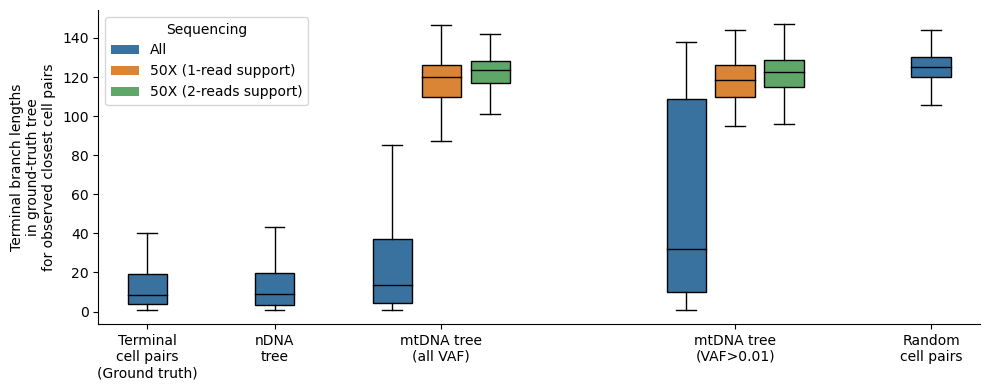

In [64]:
fig, ax = plt.subplots(figsize=(10,4))
# colors=sns.color_palette(['tab:blue','tab:blue','tab:blue','tab:orange','tab:blue','tab:orange'])
medianprops = dict(color='black')

bp = ax.boxplot([dist_gt100, dist_ndna100, 
                 dist_mt100, dist_mt_seq1100, dist_mt_seq2100, 
                 dist_mt1100, dist_mt1_seq1100, dist_mt1_seq2100, 
                 dist_random100], widths=0.4, patch_artist=True, medianprops=medianprops,showfliers=False,
                positions=[1,2.3,3.5,4,4.5,6.5,7,7.5,9]
               )

colors = ['#3a729f','#3a729f','#3a729f','#da8435', '#5ea769','#3a729f','#da8435', '#5ea769', '#3a729f'] 
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
legend_elements = []
legend_elements.append(Patch(facecolor='#3a729f',label='All'))
legend_elements.append(Patch(facecolor='#da8435',label='50X (1-read support)'))
legend_elements.append(Patch(facecolor='#5ea769',label='50X (2-reads support)'))
ax.legend(handles=legend_elements, title='Sequencing', loc=2)
ax.set_xticks([1,2.3,4, 7, 9], 
              ['Terminal\ncell pairs\n(Ground truth)','nDNA\ntree','mtDNA tree\n(all VAF)', 'mtDNA tree\n(VAF>0.01)', 'Random\ncell pairs'])
ax.set_ylabel('Terminal branch lengths\nin ground-truth tree\nfor observed closest cell pairs')
# ax.set_title('Root cell heteroplasmy = 10')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
# plt.savefig('../figs/terminal_bl_h100_r2.pdf')

In [51]:
np.mean(dist_gt100)

1.332

In [52]:
np.max(dist_gt100)

4.5

In [53]:
np.min(dist_gt100)

1.0

  0%|          | 0/2000 [00:00<?, ?it/s]

/home/wangkun/mtDNA_simulation/scripts/../mtDNAsim/sim_utils.py:793: RuntimeWarning: invalid value encountered in divide
  freq_samp = rc/depth


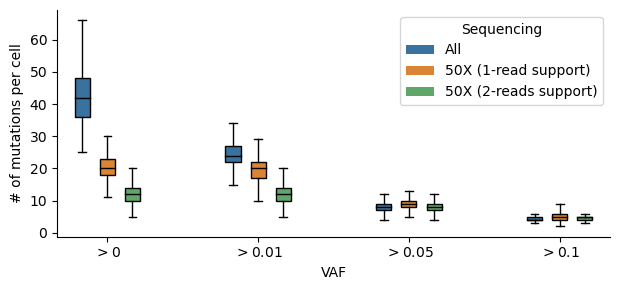

In [33]:
path = f'{data_path}/{simid}/'
if '_100' in path:
    hp = 100
else:
    hp = 10
# for gen in [30, 130, 330]:
gen = 130
mts = pickle.load(open(f'{path}mt_allmuts_{gen}.pkl', 'rb'))
mt_freq = sparse_freq(mts)
if gen == 30:
    tree = Phylo.read(f'{path}/gt_tree.nwk', 'newick')
    sel_cells = [i.name for i in tree.get_terminals()]
    mt_freq = mt_freq.loc[sel_cells]

mt_freq_samp1, mt_freq_samp2 = sequence_sim(mt_freq, 50, n=2.5, min_reads=[1,2])

num_vaf = []
for i in [0,0.01,0.05,0.1]:
    for freq_i in (mt_freq, mt_freq_samp1, mt_freq_samp2):
        num_vaf.append(np.sum(freq_i>i, axis=1).to_numpy())
fig, ax = plt.subplots(1, 1, figsize=(6.3, 3))
medianprops = dict(color='black')
bp = ax.boxplot(num_vaf, positions=[0.5,1,1.5,3.5,4,4.5,6.5,7,7.5,9.5,10,10.5],
                widths=0.3, patch_artist=True, medianprops=medianprops,showfliers=False)
ax.set_xlabel('VAF')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
colors=['#3a729f','#da8435', '#5ea769','#3a729f','#da8435','#5ea769','#3a729f','#da8435','#5ea769','#3a729f','#da8435','#5ea769']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
ax.set_ylabel('# of mutations per cell')
legend_elements = []
legend_elements.append(Patch(facecolor='#3a729f',label='All'))
legend_elements.append(Patch(facecolor='#da8435',label='50X (1-read support)'))
legend_elements.append(Patch(facecolor='#5ea769',label='50X (2-reads support)'))
ax.legend(handles=legend_elements, title='Sequencing', loc=1)
ax.set_xticks([1,4,7,10], 
              ['$>0$', '$>0.01$', '$>0.05$', '$>0.1$'])
plt.tight_layout()
# plt.savefig(f'../figs/vaf_{gen}_heterp{hp}_r2.pdf')

In [37]:
from collections import Counter
gen = 130
clones = [i.name.split('>')[0]+'>' for i in tree_gt.get_terminals()]
clones_cnt = Counter(clones)
# clones = list(set([i.name.split('>')[0]+'>' for i in treegt.get_terminals()]))
# colors = ['#5D8AA8','#E32636','#FFBF00','#A4C639','#FBCEB1','#7FFFD4','#4B5320','#3B444B','#E9D66B','#B2BEB5','#FF9966','#6D351A','#007FFF','#89CFF0','#98777B','#DE5D83','#66FF00','#BF94E4','#FF007F','#004225','#FFC1CC','#800020']
colors = ['#5BD17E','#D6D0FA','#FA937F','#C6E7CE','#E48DD0','#FFC33C','#8AE0DF','#82B329','#7475E6','#FBE2B4','#8F4851','#2040BD','#A5BFFA','#B500EB','#00992B','#724094','#FC6621','#CC2A27','#C2459F','#670755']        
header = ['DATASET_COLORSTRIP','SEPARATOR SPACE','DATASET_LABEL label1','COLOR #ff0000','STRIP_WIDTH 120', 'DATA']
# header = []
if len(clones_cnt.keys()) <= 20:
    color_tab = dict(zip([i[0] for i in clones_cnt.most_common()], colors[:len(clones_cnt.keys())]))
    with open(f'{path}/tree_color{gen}.txt', 'w') as f:
        f.write('\n'.join(header))
        f.write('\n')
        for i in tree_gt.get_terminals():
            f.write(f"{i.name} {color_tab[i.name.split('>')[0]+'>']}\n")
else:
    progenitors = [tree_gt.root]
    iters = 0
    while len(progenitors)<20:
        iters += 1
        if iters > 100:
            print('unsuccess')
            break
        try:
            progenitors.append(progenitors[0].clades[0])
            progenitors.append(progenitors[0].clades[1])
        except:
            pass
        progenitors.pop(0)
    cnt = [len(i.get_terminals()) for i in progenitors]
    with open(f'{path}/tree_color{gen}.txt', 'w') as f:
        f.write('\n'.join(header))
        f.write('\n')
        for ind, i in enumerate(np.argsort(cnt)[::-1]):
            for j in progenitors[i].get_terminals():
                f.write(f'{j.name} {colors[ind]}\n')
